<a href="https://colab.research.google.com/github/JayNakum/OperatingSystemsProject/blob/main/FCFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up firebase

In [ ]:
# imports
import firebase_admin
from firebase_admin import credentials, firestore

# get the credential certificate from json file
cred = credentials.Certificate('jaynakum-experiments-88cc723f2db9.json')
# using the credentials initialize the firebase app
default_app = firebase_admin.initialize_app(cred, {'storageBucket': 'jaynakum-experiments.appspot.com'})
# initialize the database
db = firestore.client()

# initialize the main document reference
doc_ref = db.collection(u'CPU Scheduling')


## Generate gantt chart and output table

In [ ]:
# imports
from matplotlib import pyplot as plt
from firebase_admin import storage

# method to generate gantt chart
def generateGanttChart(ganttChart: list) -> None:
  # create a figure and a set of subplots
  fig, gnt = plt.subplots()

  # set x-axis limit from 0 to the last entry of gantt chart
  gnt.set_xlim(0, ganttChart[(len(ganttChart) - 1)]['Exit Time'] + 1)
  # set y-axis limit to 1 because the chart is one line only
  gnt.set_ylim(0, 1)

  # set labels for both the axis
  gnt.set_xlabel('Time')
  gnt.set_ylabel('Process ID')

  # set y ticks and set labels = '' because there is no need to display it
  gnt.set_yticks([10, 20])
  gnt.set_yticklabels(['', ''])

  # the chart alternates between green and blue color
  # _isGreen flag is used to determine the color of broken_barh [broken bar horizontal]
  _isGreen = True
  for gantt in ganttChart:
    # _isGreen alternates between true and false
    _isGreen = not _isGreen
    # if true draw with green color else draw with blue
    if(_isGreen):
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4), facecolors=('tab:green'))
    else:
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4))
    # annotate the chart with the process' ID
    gnt.annotate(gantt['Process ID'], (gantt['Start Time'] + 0.2, 9.7))

  # save the output file
  plt.savefig('output/ganttChart.png')
  fileName = 'output/ganttChart.png'
  # print('Gantt Chart generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)

# method to generate output table
def generateOutput(outputProcesses: list, avgWT: int, avgTAT: int) -> None:
  # initializing a list of column lables
  columnLables = [
    'Process ID',
    'Arrival Time',
    'Burst Time',
    'Waiting Time',
    'Completion Time',
    'Turn Around Time',
    'Response Time'
  ]

  # making a list of each row(as list) from output 
  values = [[outputProcesses[i]['Process ID'], outputProcesses[i]['Arrival Time'], outputProcesses[i]['Burst Time'], outputProcesses[i]['Waiting Time'], outputProcesses[i]['Completion Time'], outputProcesses[i]['Turn Around Time'], outputProcesses[i]['Response Time']]for i in range(0, len(outputProcesses))]

  # set size and layout of output figure
  plt.rcParams["figure.figsize"] = [11.0, 3.0]
  plt.rcParams["figure.autolayout"] = True
  # create a figure and a set of subplots
  fig, table = plt.subplots()
  
  # turn off x and y axis
  table.set_axis_off()
  # enter the data into the table
  # cellText = values and colLabels = columnLabels with location center
  outputTable = table.table(cellText=values, colLabels=columnLables, cellLoc='center', loc='center')
  # scale the output image
  outputTable.scale(1.5, 1.5)
  # print 'Average Waiting Time' and 'Average Turn Around Time' in the image
  table.set_title('Average Waiting Time = ' + str(avgWT) + '\nAverage Turn Around Time = ' + str(avgTAT))

  # save the output file
  plt.savefig('output/outputTable.png')
  fileName = 'output/outputTable.png'
  # print('Output Table generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)


## First Come First Serve

In [ ]:
# main FCFS class for simulation of first come first serve algorithm
class FCFS:

  def __init__(self, processes: list) -> None:
    # global time variable to keep track of all the timings
    self.time = 0
    # list of all processes where each process is a dict
    self.processes = processes
    # calculating the number of processes
    self.numberOfProcesses = len(processes)

  # simulate method performs the simulation
  def simulate(self) -> None:
    # initializing a list to store a dict of PID, Start Time and Exit Time
    ganttChart = []

    # the simulation
    for process in self.processes: # TIME COMPLEXITY: O(n)

      # check for an empty state
      if(process['Arrival Time'] > self.time):
        self.time += (process['Arrival Time'] - self.time)

      # note the 'Response Time' of each process
      if 'Response Time' in process.keys():
        pass
      else:
        process['Response Time'] = (self.time - process['Arrival Time'])

      # add the values to gantt chart
      # where start time = global time and exit time = global time + 'Burst Time'
      ganttChart.append({'Process ID': process['Process ID'], 'Start Time': self.time, 'Exit Time': self.time + process['Burst Time']})
      # increment the global time
      self.time += process['Burst Time']
      # note the 'Completion Time'
      process['Completion Time'] = self.time
    
    # generate and upload gantt chart image
    generateGanttChart(ganttChart)

  # method to calculate TAT, WT and average of TAT and WT
  def calculateTimes(self) -> int:
    sumTAT = 0
    sumWT = 0

    # iterate through each process and calculate its times
    for process in self.processes: # TIME COMPLEXITY: O(n)
      # turn around time = completion time - arrival time
      process['Turn Around Time'] = process['Completion Time'] - process['Arrival Time']
      # waiting time = turn around time - birst time
      process['Waiting Time'] = process['Turn Around Time'] - process['Burst Time']

      # calculate the sum
      sumTAT += process['Turn Around Time']
      sumWT += process['Waiting Time']
    # calculate average using the sum
    avgWT = (sumWT / self.numberOfProcesses)
    avgTAT = (sumTAT / self.numberOfProcesses)
    # generate and upload output table image
    generateOutput(self.processes, avgWT, avgTAT)


### Print output to console [OPTIONAL]

In [ ]:
# this is an optional method
# it prints the output to console in a readable format
def printFormattedOutput() -> None:

    print()
    print('PID = Process ID')
    print('ST = Start Time')
    print('ET = Exit Time')

    print()
    print('PID\tST\tET')
    for gantt in output['Gantt Chart']:
        id = str(gantt['Process ID'])
        st = str(gantt['Start Time'])
        et = str(gantt['Exit Time'])
        print(id + '\t' + st + '\t' + et)

    print()
    print('PID = Process ID')
    print('AT = Arrival Time')
    print('BT = Burst Time')
    print('CT = Completion Time')
    print('TAT = Turn Around Time')
    print('WT = Waiting Time')
    print('RT = Response Time')

    print()
    print('PID\tAT\tBT\tCT\tTAT\tWT\tRT')
    for process in output['Processes']:
        pid = str(process['Process ID'])
        at = str(process['Arrival Time'])
        bt = str(process['Burst Time'])
        ct = str(process['Completion Time'])
        tat = str(process['Turn Around Time'])
        wt = str(process['Waiting Time'])
        rt = str(process['Response Time'])
        print(pid + '\t' + at + '\t' + bt + '\t' +
              ct + '\t' + tat + '\t' + wt + '\t' + rt)

    print()
    print('Average Waiting Time = ' + str(output['Average Waiting Time']))
    print('Average Turn Around Time = ' + str(output['Average Turn Around Time']))


## Get input from firebase

Received new document snapshot: First Come First Serve
[{'Process ID': 0, 'Burst Time': 1, 'Arrival Time': 0}, {'Burst Time': 5, 'Arrival Time': 2, 'Process ID': 1}, {'Process ID': 2, 'Arrival Time': 3, 'Burst Time': 5}]


KeyboardInterrupt: ignored

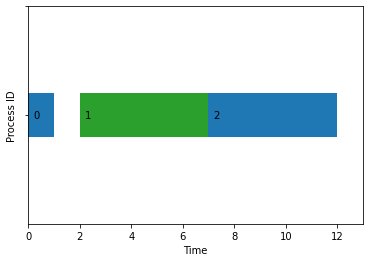

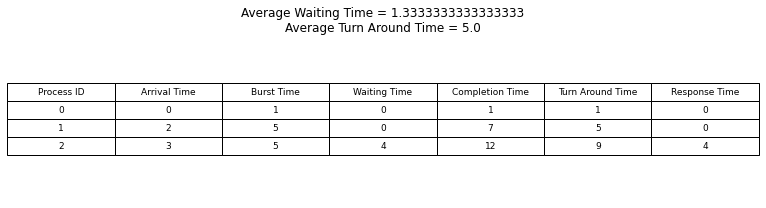

In [ ]:
# imports
import threading
import time

# Create an Event for notifying main thread.
callback_done = threading.Event()

# Create a callback on_snapshot function to capture changes
def on_snapshot(doc_snapshot, changes, read_time):
  for change in changes:
    # Check for a change in document
    if change.type.name == 'MODIFIED':
      # print(u'Change: {}'.format(change.document.id))
      # iterate through each document snapshot
      for doc in doc_snapshot:
        print(f'Received new document snapshot: {doc.id}')
        # initialize the input processes
        input = doc.to_dict()
        inputProcesses = input['Processes']
        print(inputProcesses)
        # dict containing the processes, gantt chart, average waiting time and average turn around time
        inputProcesses.sort(key=lambda process: process['Arrival Time']) # Timsort Algorithm TIME COMPLEXITY: O(nlogn)
        
        # initialize the main output dict
        output = {
            'Processes': inputProcesses,
            'Gantt Chart': [],
            'Average Waiting Time': 0,
            'Average Turn Around Time': 0
        }

        # create object of FCFS class
        fcfs = FCFS(output['Processes'])
        # and call its methods
        fcfs.simulate()
        fcfs.calculateTimes()
    # return the control to document watch
    callback_done.set()

# Watch the document
doc_watch = doc_ref.on_snapshot(on_snapshot)

# Keep the app running
while True:
    time.sleep(1)
    # print('watching')
